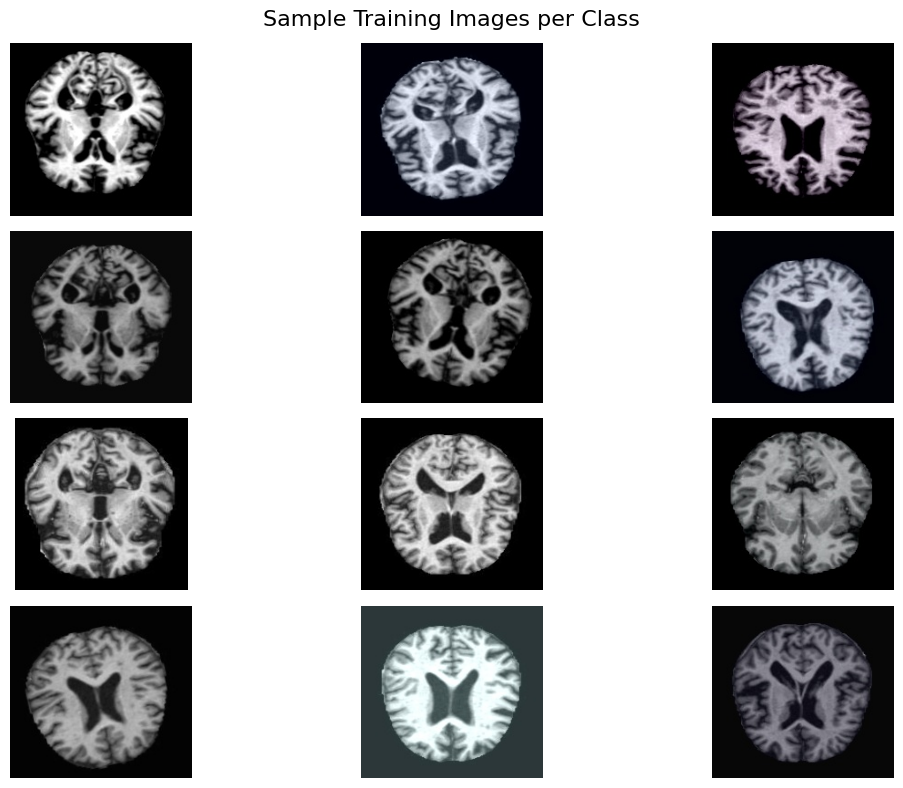

In [1]:
# ==========================================
# SHOW SAMPLE IMAGES PER CLASS (KAGGLE)
# ==========================================

import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# --------------------
# Dataset Paths
# --------------------
TRAIN_DIR = "/kaggle/input/datasets/ihsafy/resnet-v200/data/train"

CLASSES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

NUM_IMAGES = 3

# --------------------
# Plot Images
# --------------------
plt.figure(figsize=(12, 8))
plot_index = 1

for class_name in CLASSES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    
    images = os.listdir(class_path)
    selected_images = random.sample(images, NUM_IMAGES)
    
    for img_name in selected_images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert("RGB")
        
        plt.subplot(len(CLASSES), NUM_IMAGES, plot_index)
        plt.imshow(img)
        plt.axis("off")
        
        if plot_index % NUM_IMAGES == 1:
            plt.ylabel(class_name, fontsize=12)
        
        plot_index += 1

plt.suptitle("Sample Training Images per Class", fontsize=16)
plt.tight_layout()
plt.show()

Image count per class:

MildDemented: 8960
ModerateDemented: 6464
NonDemented: 9600
VeryMildDemented: 8960


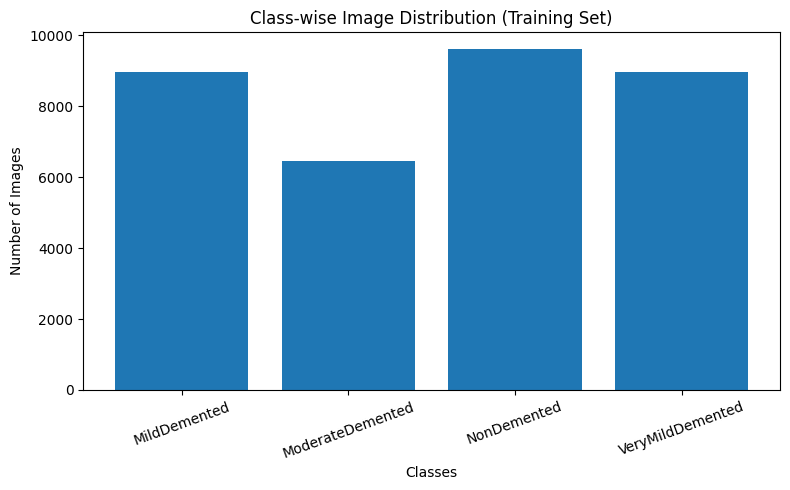

In [2]:
# ==========================================
# CLASS DISTRIBUTION GRAPH (KAGGLE)
# ==========================================

import os
import matplotlib.pyplot as plt

# --------------------
# Dataset Path
# --------------------
TRAIN_DIR = "/kaggle/input/datasets/ihsafy/resnet-v200/data/train"

CLASSES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

# --------------------
# Count Images
# --------------------
class_counts = {}

for class_name in CLASSES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# --------------------
# Print Counts
# --------------------
print("Image count per class:\n")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# --------------------
# Plot Bar Chart
# --------------------
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Image Distribution (Training Set)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [3]:
# ============================================================
# INCEPTION-RESNET-V2 | 
# ============================================================

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# -----------------------------
# Paths
# -----------------------------
TRAIN_DIR = "/kaggle/input/datasets/ihsafy/resnet-v200/data/train"
VAL_DIR   = "/kaggle/input/datasets/ihsafy/resnet-v200/data/val"

# -----------------------------
# Hyperparameters (TUNED)
# -----------------------------
IMG_SIZE = (299, 299)   # Required for Inception
BATCH_SIZE = 16         # Lower batch for stability
EPOCHS_STAGE_1 = 15
EPOCHS_STAGE_2 = 20
NUM_CLASSES = 4
INIT_LR = 1e-4
FINE_TUNE_LR = 1e-5

# -----------------------------
# Data Generators
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# -----------------------------
# Class Weights (IMPORTANT)
# -----------------------------
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -----------------------------
# Base Model
# -----------------------------
base_model = InceptionResNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(299, 299, 3)
)

base_model.trainable = False  # Stage 1: Freeze backbone

# -----------------------------
# Classification Head (STRONG)
# -----------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# -----------------------------
# Compile (Stage 1)
# -----------------------------
model.compile(
    optimizer=Adam(learning_rate=INIT_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -----------------------------
# Callbacks
# -----------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6),
    ModelCheckpoint(
        "inception_resnet_v2_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

# -----------------------------
# TRAINING – STAGE 1
# -----------------------------
print("\n🔹 Stage 1: Training classification head")
history_stage_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE_1,
    class_weight=class_weights,
    callbacks=callbacks
)

# -----------------------------
# Fine-Tuning (UNFREEZE TOP)
# -----------------------------
print("\n🔹 Stage 2: Fine-tuning top layers")

for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_stage_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_STAGE_2,
    class_weight=class_weights,
    callbacks=callbacks
)

# -----------------------------
# Save Final Model
# -----------------------------
model.save("inception_resnet_v2_final.h5")
print("\n✅ Final model saved successfully")

2026-02-21 08:58:23.215268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771664303.670665      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771664303.763180      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771664304.819171      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771664304.819220      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771664304.819227      55 computation_placer.cc:177] computation placer alr

Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Class Weights: {0: np.float64(0.9482142857142857), 1: np.float64(1.3143564356435644), 2: np.float64(0.885), 3: np.float64(0.9482142857142857)}


I0000 00:00:1771664364.474435      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1771664364.480470      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 55,262,180 (210.81 MB)

 Trainable params: 922,372 (3.52 MB)

 Non-trainable params: 54,339,808 (207.29 MB)


🔹 Stage 1: Training classification head


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1771664389.439438     144 service.cc:152] XLA service 0x788270002600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771664389.439477     144 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771664389.439482     144 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771664395.171814     144 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771664405.697647     144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4455 - loss: 1.3445
Epoch 1: val_accuracy improved from -inf to 0.58578, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 911s 414ms/step - accuracy: 0.4455 - loss: 1.3444 - val_accuracy: 0.5858 - val_loss: 0.8610 - learning_rate: 1.0000e-04
Epoch 2/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5816 - loss: 0.8934
Epoch 2: val_accuracy improved from 0.58578 to 0.59344, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 750s 353ms/step - accuracy: 0.5816 - loss: 0.8934 - val_accuracy: 0.5934 - val_loss: 0.8752 - learning_rate: 1.0000e-04
Epoch 3/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.6133 - loss: 0.8069
Epoch 3: val_accuracy improved from 0.59344 to 0.61172, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 744s 350ms/step - accuracy: 0.6133 - loss: 0.8069 - val_accuracy: 0.6117 - val_loss: 0.8073 - learning_rate: 1.0000e-04
Epoch 4/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6299 - loss: 0.7669
Epoch 4: val_accuracy improved from 0.61172 to 0.61281, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 756s 356ms/step - accuracy: 0.6299 - loss: 0.7669 - val_accuracy: 0.6128 - val_loss: 0.7922 - learning_rate: 1.0000e-04
Epoch 5/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.6531 - loss: 0.7267
Epoch 5: val_accuracy improved from 0.61281 to 0.65047, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 757s 356ms/step - accuracy: 0.6531 - loss: 0.7267 - val_accuracy: 0.6505 - val_loss: 0.7503 - learning_rate: 1.0000e-04
Epoch 6/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6581 - loss: 0.7114
Epoch 6: val_accuracy improved from 0.65047 to 0.65734, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 763s 359ms/step - accuracy: 0.6581 - loss: 0.7114 - val_accuracy: 0.6573 - val_loss: 0.7316 - learning_rate: 1.0000e-04
Epoch 7/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.6724 - loss: 0.6823
Epoch 7: val_accuracy improved from 0.65734 to 0.67109, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 759s 357ms/step - accuracy: 0.6724 - loss: 0.6823 - val_accuracy: 0.6711 - val_loss: 0.6983 - learning_rate: 1.0000e-04
Epoch 8/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6756 - loss: 0.6710
Epoch 8: val_accuracy did not improve from 0.67109
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 775s 365ms/step - accuracy: 0.6756 - loss: 0.6710 - val_accuracy: 0.6677 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 9/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6866 - loss: 0.6543
Epoch 9: val_accuracy improved from 0.67109 to 0.67406, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 776s 365ms/step - accuracy: 0.6866 - loss: 0.6543 - val_accuracy: 0.6741 - val_loss: 0.6895 - learning_rate: 1.0000e-04
Epoch 10/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6980 - loss: 0.6365
Epoch 10: val_accuracy improved from 0.67406 to 0.70203, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 785s 370ms/step - accuracy: 0.6980 - loss: 0.6365 - val_accuracy: 0.7020 - val_loss: 0.6783 - learning_rate: 1.0000e-04
Epoch 11/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7010 - loss: 0.6228
Epoch 11: val_accuracy did not improve from 0.70203
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 776s 365ms/step - accuracy: 0.7010 - loss: 0.6228 - val_accuracy: 0.6775 - val_loss: 0.6840 - learning_rate: 1.0000e-04
Epoch 12/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7060 - loss: 0.6099
Epoch 12: val_accuracy improved from 0.70203 to 0.70422, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 781s 368ms/step - accuracy: 0.7060 - loss: 0.6099 - val_accuracy: 0.7042 - val_loss: 0.6607 - learning_rate: 1.0000e-04
Epoch 13/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.7150 - loss: 0.6006
Epoch 13: val_accuracy improved from 0.70422 to 0.70969, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 766s 361ms/step - accuracy: 0.7150 - loss: 0.6006 - val_accuracy: 0.7097 - val_loss: 0.6421 - learning_rate: 1.0000e-04
Epoch 14/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7219 - loss: 0.5916
Epoch 14: val_accuracy did not improve from 0.70969
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 760s 358ms/step - accuracy: 0.7219 - loss: 0.5916 - val_accuracy: 0.7016 - val_loss: 0.6444 - learning_rate: 1.0000e-04
Epoch 15/15
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.7190 - loss: 0.5867
Epoch 15: val_accuracy improved from 0.70969 to 0.73094, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 762s 359ms/step - accuracy: 0.7190 - loss: 0.5867 - val_accuracy: 0.7309 - val_loss: 0.6118 - learning_rate: 1.0000e-04

🔹 Stage 2: Fine-tuning top layers
Epoch 1/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6912 - loss: 0.6741
Epoch 1: val_accuracy improved from 0.73094 to 0.73656, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 826s 370ms/step - accuracy: 0.6912 - loss: 0.6740 - val_accuracy: 0.7366 - val_loss: 0.5831 - learning_rate: 1.0000e-05
Epoch 2/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7528 - loss: 0.5177
Epoch 2: val_accuracy improved from 0.73656 to 0.77750, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 777s 366ms/step - accuracy: 0.7528 - loss: 0.5176 - val_accuracy: 0.7775 - val_loss: 0.4973 - learning_rate: 1.0000e-05
Epoch 3/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7850 - loss: 0.4577
Epoch 3: val_accuracy improved from 0.77750 to 0.81391, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 789s 371ms/step - accuracy: 0.7850 - loss: 0.4577 - val_accuracy: 0.8139 - val_loss: 0.4361 - learning_rate: 1.0000e-05
Epoch 4/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8175 - loss: 0.4064
Epoch 4: val_accuracy improved from 0.81391 to 0.83047, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 779s 366ms/step - accuracy: 0.8175 - loss: 0.4064 - val_accuracy: 0.8305 - val_loss: 0.3878 - learning_rate: 1.0000e-05
Epoch 5/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8350 - loss: 0.3626
Epoch 5: val_accuracy improved from 0.83047 to 0.85906, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 781s 368ms/step - accuracy: 0.8350 - loss: 0.3626 - val_accuracy: 0.8591 - val_loss: 0.3420 - learning_rate: 1.0000e-05
Epoch 6/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8549 - loss: 0.3241
Epoch 6: val_accuracy improved from 0.85906 to 0.87375, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 796s 375ms/step - accuracy: 0.8549 - loss: 0.3241 - val_accuracy: 0.8737 - val_loss: 0.2979 - learning_rate: 1.0000e-05
Epoch 7/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.8670 - loss: 0.2975
Epoch 7: val_accuracy improved from 0.87375 to 0.90516, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 757s 356ms/step - accuracy: 0.8670 - loss: 0.2975 - val_accuracy: 0.9052 - val_loss: 0.2473 - learning_rate: 1.0000e-05
Epoch 8/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.8865 - loss: 0.2591
Epoch 8: val_accuracy improved from 0.90516 to 0.91203, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 753s 355ms/step - accuracy: 0.8865 - loss: 0.2591 - val_accuracy: 0.9120 - val_loss: 0.2197 - learning_rate: 1.0000e-05
Epoch 9/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8976 - loss: 0.2384
Epoch 9: val_accuracy improved from 0.91203 to 0.93000, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 760s 358ms/step - accuracy: 0.8976 - loss: 0.2384 - val_accuracy: 0.9300 - val_loss: 0.1893 - learning_rate: 1.0000e-05
Epoch 10/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9072 - loss: 0.2185
Epoch 10: val_accuracy improved from 0.93000 to 0.93922, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 759s 357ms/step - accuracy: 0.9072 - loss: 0.2185 - val_accuracy: 0.9392 - val_loss: 0.1623 - learning_rate: 1.0000e-05
Epoch 11/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9135 - loss: 0.2028
Epoch 11: val_accuracy improved from 0.93922 to 0.94109, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 760s 358ms/step - accuracy: 0.9135 - loss: 0.2028 - val_accuracy: 0.9411 - val_loss: 0.1549 - learning_rate: 1.0000e-05
Epoch 12/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9238 - loss: 0.1841
Epoch 12: val_accuracy improved from 0.94109 to 0.94391, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 756s 356ms/step - accuracy: 0.9238 - loss: 0.1841 - val_accuracy: 0.9439 - val_loss: 0.1382 - learning_rate: 1.0000e-05
Epoch 13/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9260 - loss: 0.1750
Epoch 13: val_accuracy did not improve from 0.94391
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 757s 356ms/step - accuracy: 0.9260 - loss: 0.1750 - val_accuracy: 0.9417 - val_loss: 0.1438 - learning_rate: 1.0000e-05
Epoch 14/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9320 - loss: 0.1632
Epoch 14: val_accuracy improved from 0.94391 to 0.95328, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 758s 357ms/step - accuracy: 0.9320 - loss: 0.1632 - val_accuracy: 0.9533 - val_loss: 0.1179 - learning_rate: 1.0000e-05
Epoch 15/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9353 - loss: 0.1505
Epoch 15: val_accuracy improved from 0.95328 to 0.96500, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 759s 357ms/step - accuracy: 0.9353 - loss: 0.1505 - val_accuracy: 0.9650 - val_loss: 0.0954 - learning_rate: 1.0000e-05
Epoch 16/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9450 - loss: 0.1367
Epoch 16: val_accuracy did not improve from 0.96500
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 757s 356ms/step - accuracy: 0.9450 - loss: 0.1367 - val_accuracy: 0.9650 - val_loss: 0.0946 - learning_rate: 1.0000e-05
Epoch 17/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9510 - loss: 0.1203
Epoch 17: val_accuracy improved from 0.96500 to 0.96969, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 749s 353ms/step - accuracy: 0.9510 - loss: 0.1203 - val_accuracy: 0.9697 - val_loss: 0.0803 - learning_rate: 1.0000e-05
Epoch 18/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9507 - loss: 0.1181
Epoch 18: val_accuracy improved from 0.96969 to 0.97562, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 745s 351ms/step - accuracy: 0.9507 - loss: 0.1181 - val_accuracy: 0.9756 - val_loss: 0.0666 - learning_rate: 1.0000e-05
Epoch 19/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9546 - loss: 0.1132
Epoch 19: val_accuracy did not improve from 0.97562
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 777s 366ms/step - accuracy: 0.9546 - loss: 0.1132 - val_accuracy: 0.9747 - val_loss: 0.0695 - learning_rate: 1.0000e-05
Epoch 20/20
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9592 - loss: 0.1066
Epoch 20: val_accuracy improved from 0.97562 to 0.98078, saving model to inception_resnet_v2_best.h5


2124/2124 ━━━━━━━━━━━━━━━━━━━━ 770s 362ms/step - accuracy: 0.9592 - loss: 0.1066 - val_accuracy: 0.9808 - val_loss: 0.0571 - learning_rate: 1.0000e-05



✅ Final model saved successfully


✅ BEST model weights loaded
Found 6400 images belonging to 4 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step

🎯 Accuracy: 0.9808

📄 Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      0.99      0.99       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       0.98      0.99      0.98      3200
VeryMildDemented       0.98      0.97      0.97      2240

        accuracy                           0.98      6400
       macro avg       0.99      0.99      0.99      6400
    weighted avg       0.98      0.98      0.98      6400



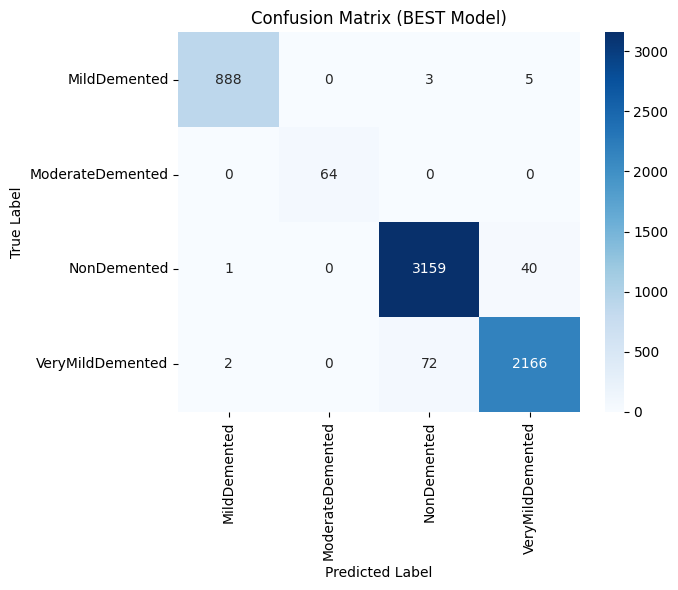


📈 Overall ROC-AUC: 0.9991


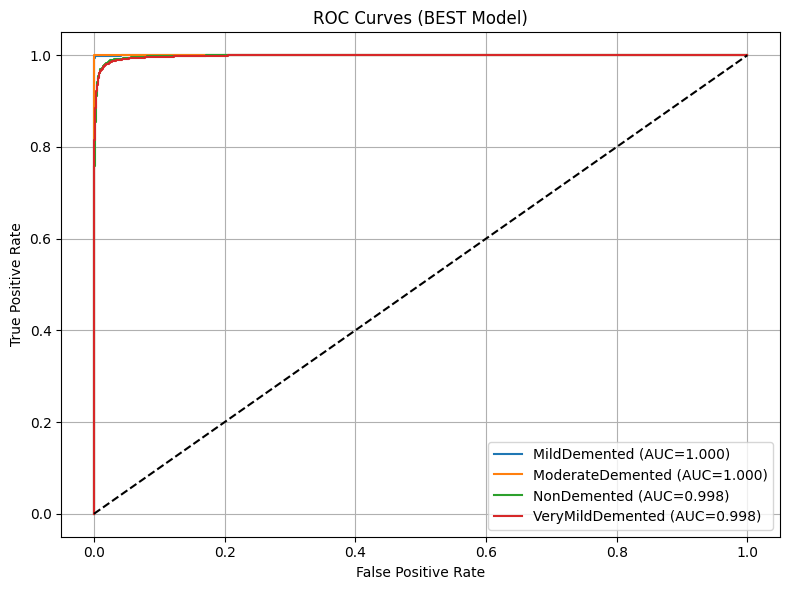

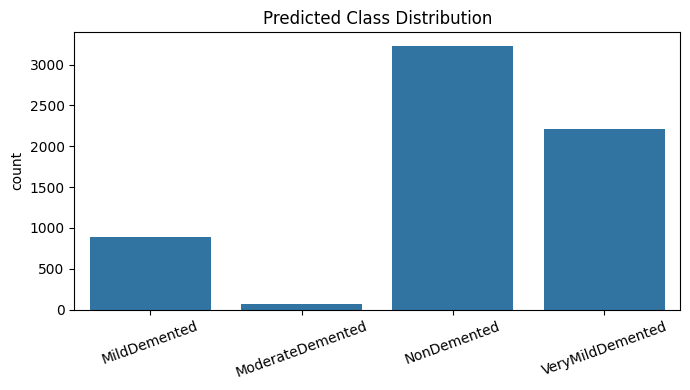

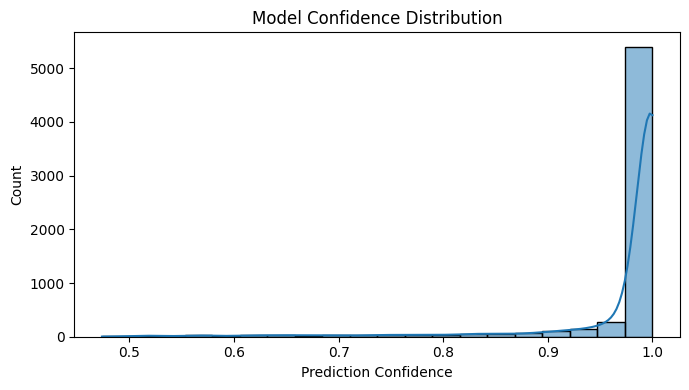


✅ Final evaluation completed successfully


In [9]:
# ============================================================
# FINAL EVALUATION (ONE MODEL ONLY – BEST CHECKPOINT)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# -----------------------------
# PATHS
# -----------------------------
WEIGHTS_PATH = "/kaggle/working/inception_resnet_v2_best.h5"
VAL_DIR = "/kaggle/input/datasets/ihsafy/resnet-v200/data/val"

CLASS_NAMES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

IMG_SIZE = (299, 299)
BATCH_SIZE = 16
NUM_CLASSES = 4

# ============================================================
# 1️⃣ BUILD MODEL ARCHITECTURE (SAFE)
# ============================================================
base_model = InceptionResNetV2(
    weights=None,
    include_top=False,
    input_shape=(299, 299, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Load trained weights
model.load_weights(WEIGHTS_PATH)
print("✅ BEST model weights loaded")

# ============================================================
# 2️⃣ VALIDATION DATA
# ============================================================
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

y_true = val_gen.classes

# ============================================================
# 3️⃣ PREDICTIONS
# ============================================================
y_prob = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# ============================================================
# 4️⃣ ACCURACY
# ============================================================
print(f"\n🎯 Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# ============================================================
# 5️⃣ PRECISION / RECALL / F1
# ============================================================
print("\n📄 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# ============================================================
# 6️⃣ CONFUSION MATRIX (HEATMAP)
# ============================================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (BEST Model)")
plt.tight_layout()
plt.show()

# ============================================================
# 7️⃣ ROC-AUC (OVERALL + PER CLASS)
# ============================================================
print(f"\n📈 Overall ROC-AUC: {roc_auc_score(y_true, y_prob, multi_class='ovr'):.4f}")

plt.figure(figsize=(8, 6))
for i, cls in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
    auc = roc_auc_score(y_true == i, y_prob[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (BEST Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 8️⃣ CLASS PREDICTION DISTRIBUTION
# ============================================================
plt.figure(figsize=(7, 4))
sns.countplot(x=y_pred)
plt.xticks(range(NUM_CLASSES), CLASS_NAMES, rotation=20)
plt.title("Predicted Class Distribution")
plt.tight_layout()
plt.show()

# ============================================================
# 9️⃣ CONFIDENCE HISTOGRAM
# ============================================================
confidence = np.max(y_prob, axis=1)

plt.figure(figsize=(7, 4))
sns.histplot(confidence, bins=20, kde=True)
plt.xlabel("Prediction Confidence")
plt.title("Model Confidence Distribution")
plt.tight_layout()
plt.show()

print("\n✅ Final evaluation completed successfully")

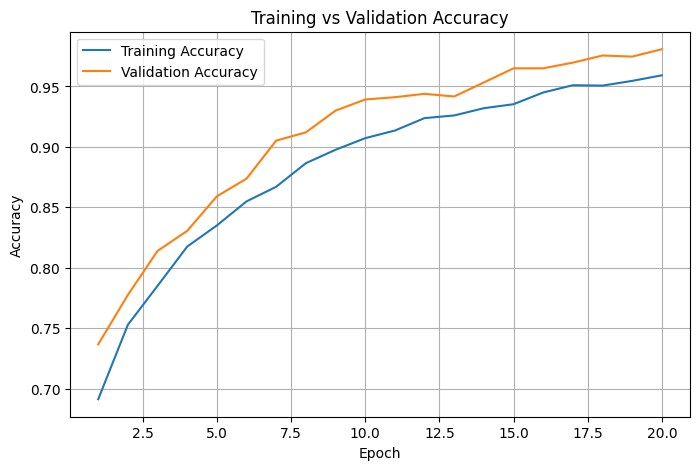

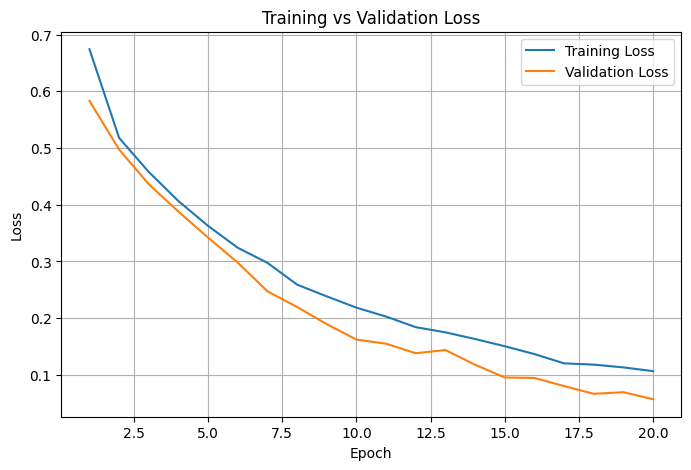


Final Validation Accuracy: 0.9808
Final Validation Loss: 0.0571


In [10]:
# ============================================================
# (TRAINING PERFORMANCE)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------
# MANUALLY ENTER FINAL STAGE 2 TRAINING METRICS (FROM YOUR LOG)
# ------------------------------------------------------------

train_acc = [
0.6912, 0.7528, 0.7850, 0.8175, 0.8350,
0.8549, 0.8670, 0.8865, 0.8976, 0.9072,
0.9135, 0.9238, 0.9260, 0.9320, 0.9353,
0.9450, 0.9510, 0.9507, 0.9546, 0.9592
]

val_acc = [
0.7366, 0.7775, 0.8139, 0.8305, 0.8591,
0.8737, 0.9052, 0.9120, 0.9300, 0.9392,
0.9411, 0.9439, 0.9417, 0.9533, 0.9650,
0.9650, 0.9697, 0.9756, 0.9747, 0.9808
]

train_loss = [
0.6741, 0.5177, 0.4577, 0.4064, 0.3626,
0.3241, 0.2975, 0.2591, 0.2384, 0.2185,
0.2028, 0.1841, 0.1750, 0.1632, 0.1505,
0.1367, 0.1203, 0.1181, 0.1132, 0.1066
]

val_loss = [
0.5831, 0.4973, 0.4361, 0.3878, 0.3420,
0.2979, 0.2473, 0.2197, 0.1893, 0.1623,
0.1549, 0.1382, 0.1438, 0.1179, 0.0954,
0.0946, 0.0803, 0.0666, 0.0695, 0.0571
]

epochs = np.arange(1, 21)

# ============================================================
# ACCURACY CURVE
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# LOSS CURVE
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Validation Accuracy:", val_acc[-1])
print("Final Validation Loss:", val_loss[-1])

✅ Model loaded


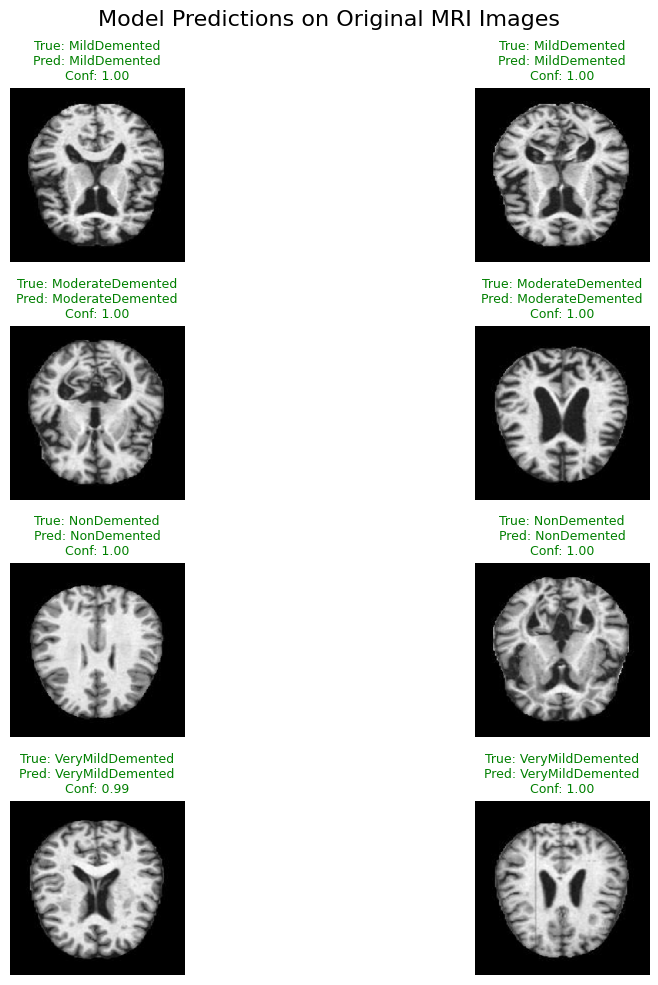

In [12]:
# ============================================================
# 
# ============================================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# -----------------------------
# PATHS
# -----------------------------
WEIGHTS_PATH = "/kaggle/working/inception_resnet_v2_best.h5"
VAL_DIR = "/kaggle/input/datasets/ihsafy/resnet-v200/data/val"

CLASS_NAMES = [
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented"
]

IMG_SIZE = (299, 299)
NUM_CLASSES = 4
IMAGES_PER_CLASS = 2

# ============================================================
# BUILD MODEL & LOAD WEIGHTS
# ============================================================
base_model = InceptionResNetV2(
    weights=None,
    include_top=False,
    input_shape=(299, 299, 3)
)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.load_weights(WEIGHTS_PATH)

print("✅ Model loaded")

# ============================================================
# VISUALIZATION (FIXED)
# ============================================================
plt.figure(figsize=(12, 10))
plot_idx = 1

for true_class in CLASS_NAMES:
    class_path = os.path.join(VAL_DIR, true_class)
    image_names = random.sample(os.listdir(class_path), IMAGES_PER_CLASS)

    for img_name in image_names:
        img_path = os.path.join(class_path, img_name)

        # Load ORIGINAL image (for display)
        original_img = load_img(img_path, target_size=IMG_SIZE)
        original_array = img_to_array(original_img).astype("uint8")

        # Prepare COPY for model (preprocessed)
        img_input = preprocess_input(
            np.expand_dims(original_array.astype("float32"), axis=0)
        )

        # Predict
        probs = model.predict(img_input, verbose=0)[0]
        pred_idx = np.argmax(probs)
        pred_class = CLASS_NAMES[pred_idx]
        confidence = probs[pred_idx]

        # Plot ORIGINAL image
        plt.subplot(len(CLASS_NAMES), IMAGES_PER_CLASS, plot_idx)
        plt.imshow(original_array)
        plt.axis("off")

        color = "green" if pred_class == true_class else "red"
        plt.title(
            f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}",
            fontsize=9,
            color=color
        )

        plot_idx += 1

plt.suptitle("Model Predictions on Original MRI Images", fontsize=16)
plt.tight_layout()
plt.show()